# Notebook for SVD analysis of the climate produced by the GAN. 

This notebook describes how to produce the figures in the article [Producing realistic climate data using GAN](https://npg.copernicus.org/articles/28/347/2021/npg-28-347-2021.html)

One should note that this repository shows the code but due to the size of the dataset the figures were reproduced with reduced dataset. Consequently, the quality of the statistical analysis is impacted. Data were created by running the Plasim simulator, for further details see the article. 

The dataset is composed of the daily images of different variable (temperature, wind components, humidity...) on a 64 by 128 pixel grid with 10 levels of altitude over the globe, projected using the PlateCarre projection. These images were standardized with respect to each variable and each level of altitude, the mean and std are stored in the "scaling" dataset.  

In [8]:
#Import of necessary packages and memory allocation.
%matplotlib inline

import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(1)
set_session(tf.Session(config=config))
import time
import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math
from sklearn.decomposition import PCA
#s = np.random.seed(1)

2022-05-19 09:57:47.489346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 09:57:47.489510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 major: 8 minor: 6 memoryClockRate(GHz): 1.755
pciBusID: 0000:06:00.0
2022-05-19 09:57:47.489658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/local/cuda-11.3/lib64
2022-05-19 09:57:47.489713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib

In [9]:
#Plot parameters.
from matplotlib import rc
sns.set() #Seaborn theme 
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
matplotlib.rc('font', **font)
plt.style.use('seaborn')

In [10]:
# Paths

data_folder = '../../Puma_Project/data/raw/'
data_file = 'data_plasim_3y_sc.h5' # Dataset filename 

## Notebook parameters. 

Setting up parameters for :
  - Figure generation
  - Number of samples considered for the statistical analysis (Here very low for computational purpose)
  - Longitude and latitude of grid cells
  - Different names of the 

In [11]:
#########
plot_var = True    #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

years = 1
N_train = 360*years
N_gen = 360*years     #Number of generation used for statistic analysis /!\ Memory usage important /!\
scaled = False


In [12]:
# Creation of channel list
var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = [i+'_z'+str(j) for i in var for j in lvls]
chan_titles.append('surf_press')
chan_titles.append('latitudes')
print(chan_titles)
print(len(chan_titles))

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surf_press', 'latitudes']
82


Here _X_train has a size of (samples, latitude, longitudes, variable). Variable has a size of 82 due to the different variables at differents altitude levels. Below the name of the different channels are printed : ta_z100 is for example the temperature at the pressure level 100 hPa i.e. at the surface. There is 8 different variables on the 10 pressure levels plus the surface pressure.  

In [13]:
#########
lons = np.genfromtxt(f'../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt(f'../data/raw/lat.csv', delimiter=',')


lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']

# Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.


f=h5.File(f'../data/raw/{data_file}','r')
_X_train = f['dataset']
scaling = f['scaling'][:,:]
print(scaling.shape)


print(scaling.shape)

if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save

(81, 2)
(81, 2)


## Generator loading

In the following cells the trained generator of the GAN model is loaded. The custom_objects parameter is the custom layers inside the generator that needs to be redefine at the loading. 

In [14]:
sys.path.append('../src/modeling')
sys.path.append('../src/preprocessing')
sys.path.append('../src/preparation')

from SpectralNormalizationKeras import ConvSN2D, DenseSN
from custom_classes import NearestPadding2D, WrapPadding2D
#from data_preproc import *

gen = load_model(f'../model/{runnumber}_generator.h5',
                 custom_objects = {'NearestPadding2D': NearestPadding2D,
                                   'WrapPadding2D': WrapPadding2D, 
                                   'DenseSN' :DenseSN, 
                                   'ConvSN2D': ConvSN2D})


2022-05-19 09:57:49.488205: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Data loading

Now that the dataset and the generator are loaded, N_gen samples are generated by the generator and N_train samples are loaded from the dataset to begin the statistical comparison. The differents samples are rescaled.

In [15]:
print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')

print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')


Generating samples...
Samples generated.
scaling...
scaled.
Scaling...
Scaled


In [16]:
#Creates the lattitudes fields in order to concatenate it to the database (as it was done during the WGAN training).

from mpl_toolkits.axes_grid1 import make_axes_locatable

lon=lons

#llat = np.load('../data/raw/llat.npy')
#lat = np.arange(-1,1,2./64.).reshape(64)
llat = np.expand_dims(lat, axis = 0)
llat = np.expand_dims(llat, axis = -1)
llat = llat.repeat(N_train, axis = 0)
llat = llat.repeat(128, axis = 2)


In [17]:
# which field to choose
field = 74
#Component to keep
Nc = 5

In [18]:
X = X_train[:,:,:,field]
Xg = fk_imgs[:,:,:,field]

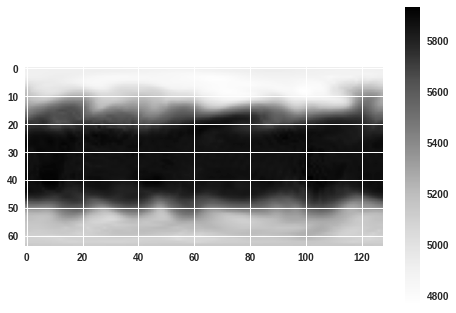

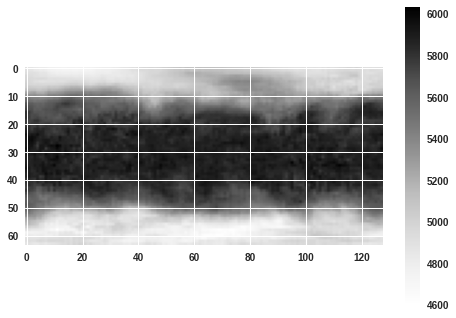

In [19]:
plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

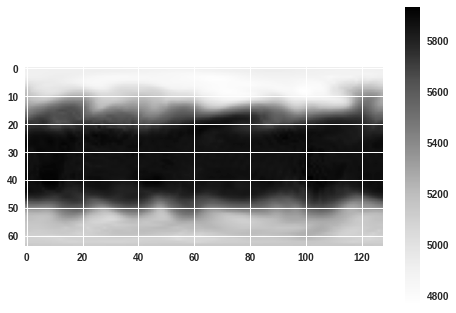

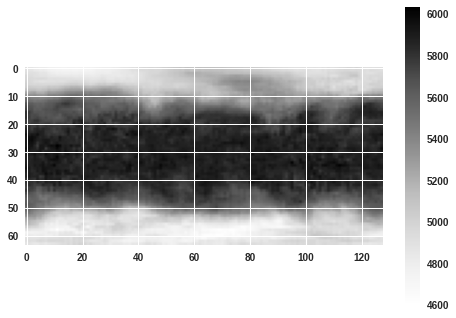

In [20]:
#X = (X - meanX)/stdX
#Xg = (Xg - meanXg)/stdXg

plt.figure()
plt.imshow(X[0,:,:])
plt.colorbar()

plt.figure()
plt.imshow(Xg[0,:,:])
plt.colorbar()

[[4909.92773438 4909.79833984 4909.70117188 ... 5130.78710938
  5130.08642578 5129.37890625]
 [4863.42480469 4864.49951172 4865.60546875 ... 5123.63964844
  5122.55322266 5121.46777344]
 [4921.83105469 4922.71826172 4923.47070312 ... 5086.93261719
  5085.29443359 5083.69921875]
 ...
 [4828.10498047 4828.00292969 4827.87548828 ... 5026.23388672
  5025.40039062 5024.58203125]
 [4843.45996094 4844.11035156 4844.66308594 ... 5087.97412109
  5086.25       5084.59765625]
 [4858.65917969 4860.21484375 4861.69238281 ... 5080.82080078
  5079.11621094 5077.54101562]]
####### SVD on dataset #######
[10806064.54528958 98443617.68450125  5723121.87623421  3772359.89379097
  2341363.40476295]
0.7686425331695392
[9489859.28592204  188258.07148952   45390.85786339   36851.7243378
   29032.58214623]
####### SVD on generated data #######
[11376424.58346474 97967187.04567064  5205605.44219191  3473837.38311942
  2968530.10254473]
0.736652784112432
[9480476.85538151  187801.80784555   43290.02142918   353

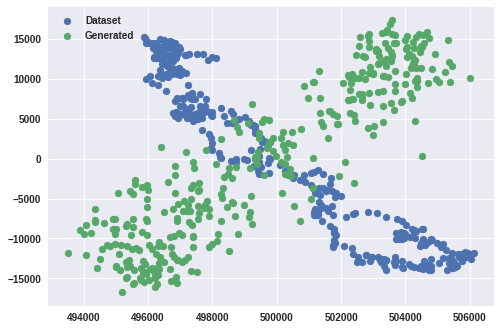

In [21]:
A = X.reshape(N_train,64*128)
Ag = Xg.reshape(N_gen,64*128)
from numpy import array
from sklearn.decomposition import TruncatedSVD
# define array
print(A)
# svd
svd = TruncatedSVD(n_components=Nc)
svd.fit(A)
At = svd.transform(A)

svdg = TruncatedSVD(n_components=Nc)
svdg.fit(Ag)
Agt = svdg.transform(Ag)

print('####### SVD on dataset #######')
print(svd.explained_variance_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

print('####### SVD on generated data #######')
print(svdg.explained_variance_)
print(svdg.explained_variance_ratio_.sum())
print(svdg.singular_values_)

Ar = svd.inverse_transform(At).reshape(X.shape)

Agr = svdg.inverse_transform(Agt).reshape(Xg.shape)

compo1 = 0
compo2 = 1
plt.figure()
plt.scatter(At[:,compo1], At[:,compo2], color='b')
plt.scatter(Agt[:,compo1], Agt[:,compo2], color='g')
plt.legend(['Dataset', 'Generated'])


In [25]:
dfd = pd.DataFrame(At, columns=[f'Component{i}' for i in range(Nc)])
dfd['parameter'] = 'dataset'
#dfd['line_color'] = 'y'
dfg = pd.DataFrame(Agt, columns=[f'Component{j}' for j in range(Nc)])
dfg['parameter'] = 'generated'
#dfg['line_color'] = 'k'

dfg.head()
frames = [dfd,dfg]

df = pd.concat(frames, ignore_index=True)
#print(df['line_color'].values)
df.head()

df[df.index.duplicated()]

,Component0,Component1,Component2,Component3,Component4,parameter


Text(0.5, 0.98, 'Component projection of SVD over 1 years simulated and generated')

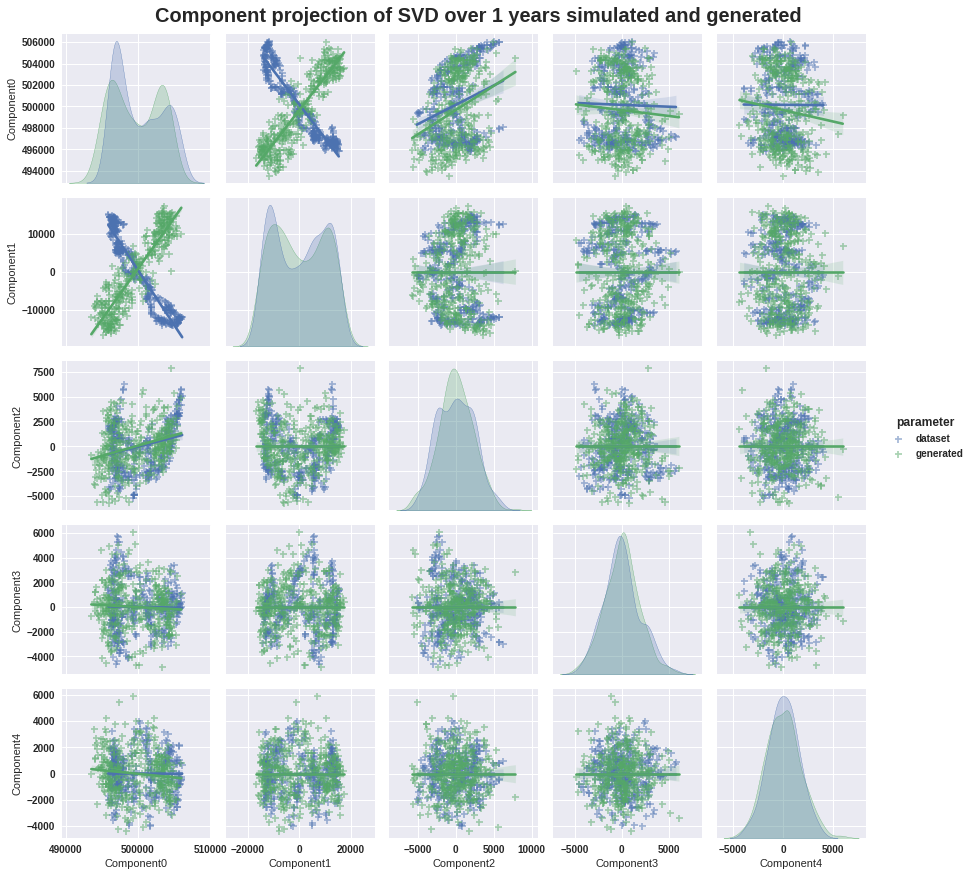

In [26]:
g = sns.pairplot(df, hue='parameter', markers='+', kind='reg',
                 plot_kws={'scatter_kws': {'alpha': 0.5}})

g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)

g.fig.suptitle(f'Component projection of SVD over {years} years simulated and generated',
               fontsize=20, fontweight='bold')

AxesSubplot(0.1,0.790947;0.164815x0.159053)
[<AxesSubplot:xlabel='Component0', ylabel='Component4'>
 <AxesSubplot:xlabel='Component1', ylabel='Component4'>
 <AxesSubplot:xlabel='Component2', ylabel='Component4'>
 <AxesSubplot:xlabel='Component3', ylabel='Component4'>
 <AxesSubplot:xlabel='Component4'>]


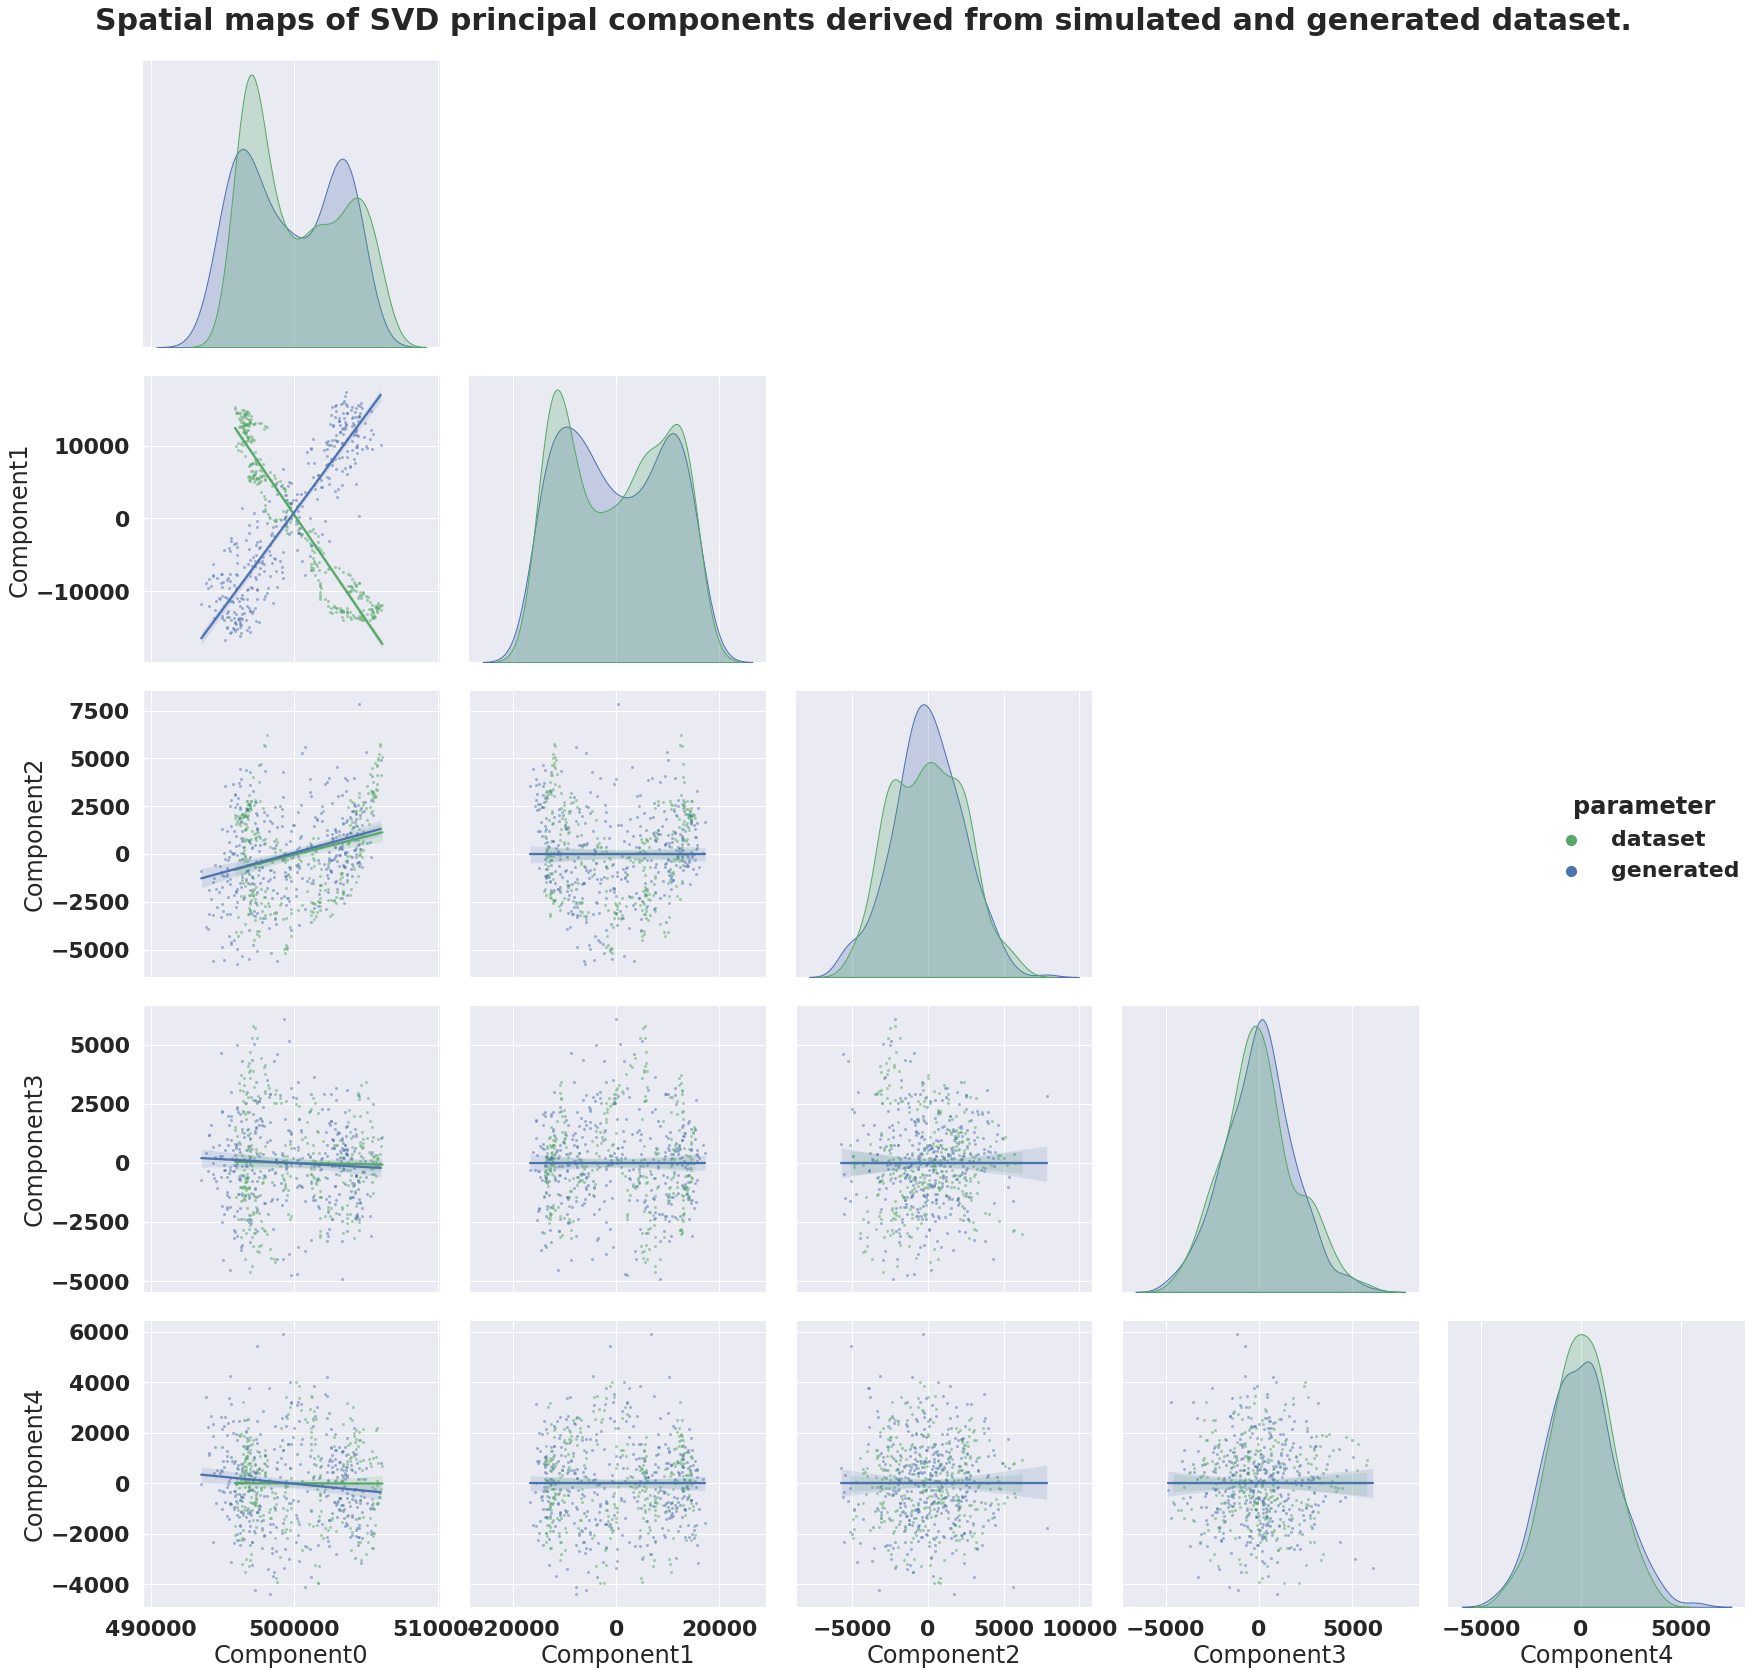

In [27]:
sns.set(font_scale = 2)

g = sns.pairplot(df, hue='parameter', markers='.', kind='reg', corner=True, palette=['g','b'],
                 plot_kws={'scatter_kws': {'alpha': .5}})
g.fig.subplots_adjust(top=0.95,right=0.99, left=0.1, wspace=0.1, hspace=0.1)
g.fig.suptitle(f'Spatial maps of SVD principal components derived from simulated and generated dataset.\n'
               , fontsize=30, fontweight='bold')
g.fig.set_size_inches(25,25)
c=0
cnt=0
pascalcnt=0
print(g.fig.axes[0])
print(g.axes[-1,:])

xlabels = ['Component0']
ax = g.axes[0,0]
ylabel = ax.yaxis.get_label_text()
#xlabels.append(xlabel)

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [500]

g.axes[0,0].yaxis.set_label_text(xlabels[0])

if save:
    plt.savefig('./fig_82c/SVD_on_data_and_generated_compo_proj_30y.pdf')


In [28]:
print(g.fig.axes[0])
print(g.axes[0,:])

AxesSubplot(0.1,0.790947;0.164815x0.159053)
[<AxesSubplot:ylabel='Component0'> None None None None]


In [29]:
print(dir(g.fig.axes[0]))
for ax in g.fig.axes:
    if len(ax.get_lines()) != 0:
        print(ax.get_lines())


['ArtistList', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alias_map', '_alpha', '_anchor', '_animated', '_aspect', '_autoscaleXon', '_autoscaleYon', '_autotitlepos', '_axes', '_axes_class', '_axes_locator', '_axis_names', '_axisbelow', '_box_aspect', '_callbacks', '_check_no_units', '_children', '_clipon', '_clippath', '_cm_set', '_colorbars', '_convert_dx', '_current_image', '_default_contains', '_deprecate_noninstance', '_facecolor', '_fill_between_x_or_y', '_frameon', '_gci', '_gen_axes_patch', '_gen_axes_spines', '_get_axis_list', '_get_axis_map', '_get_clipping_extent_bbox', '_

Text(0.5, 0.98, 'Spatial maps of SVD principal components derived from simulated and generated dataset.\n')

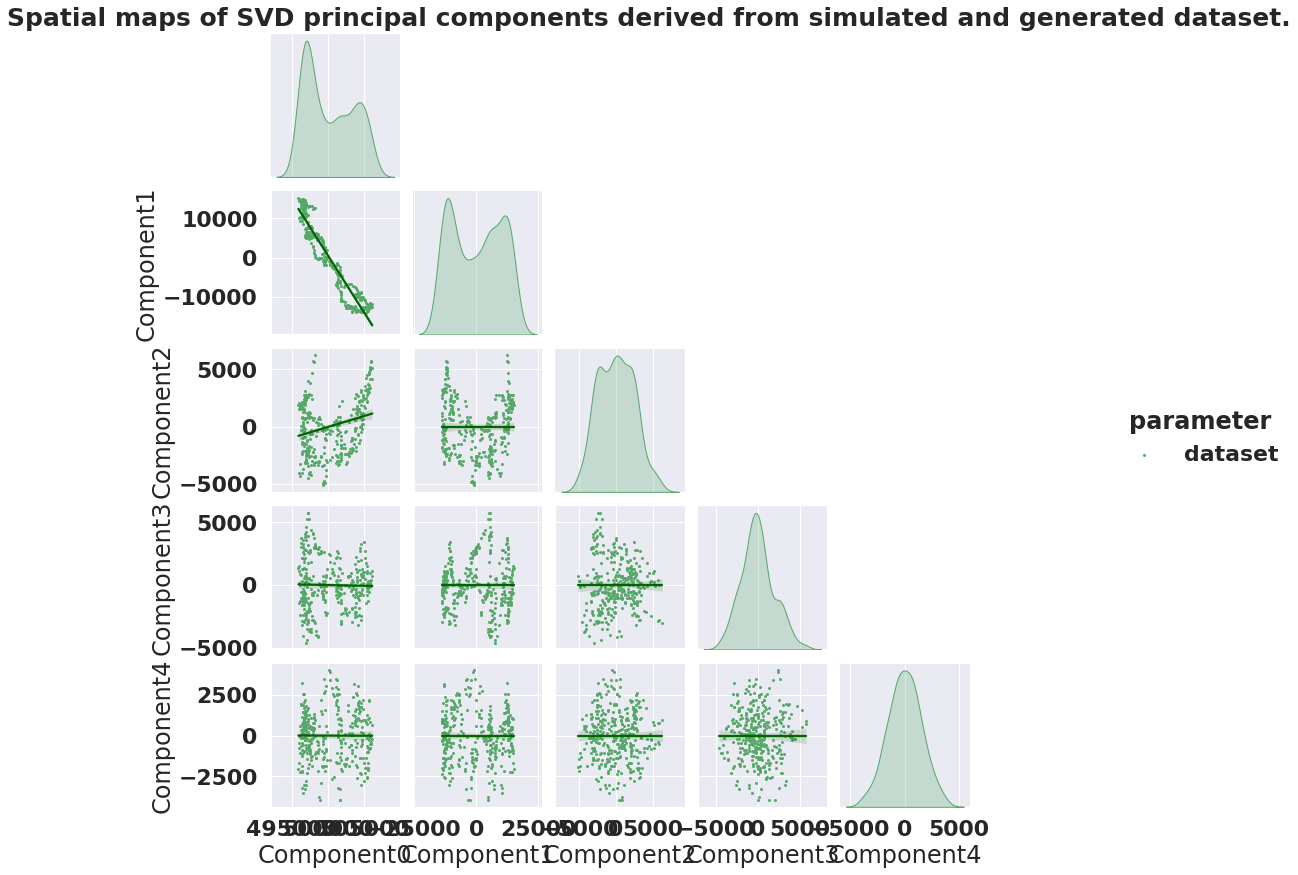

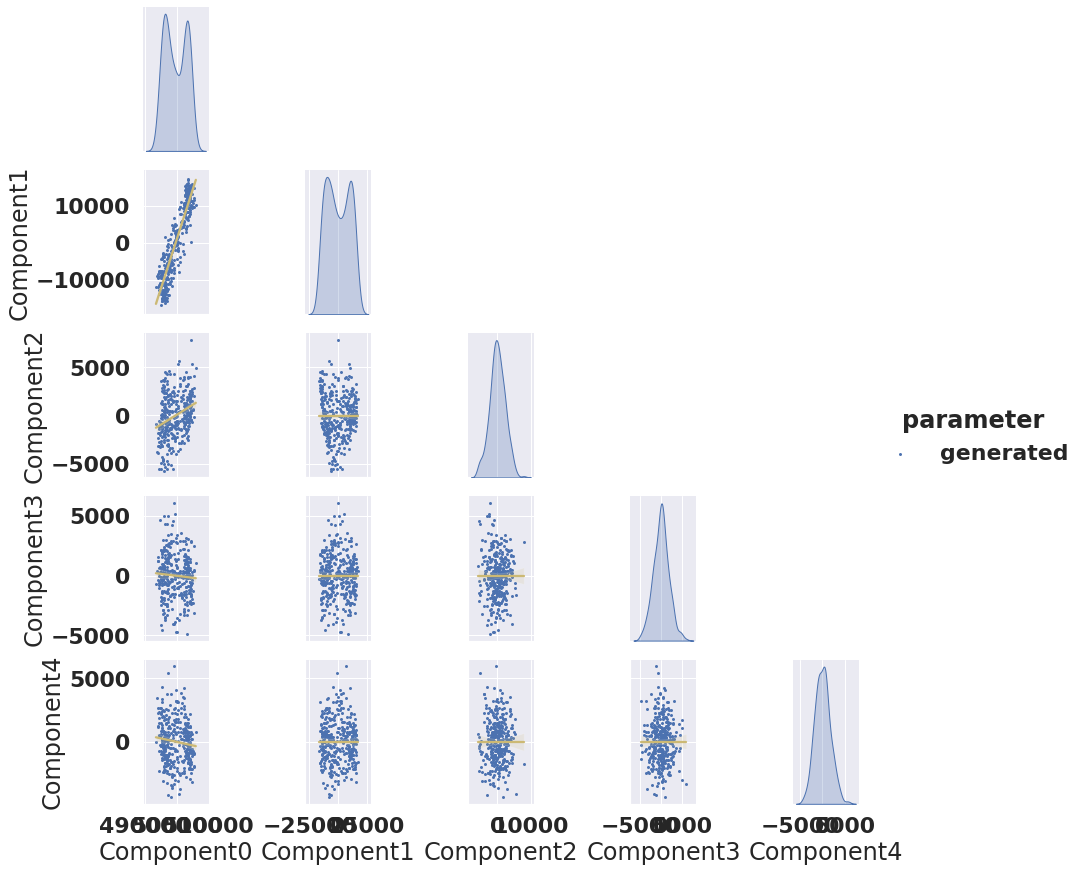

In [30]:
sns.set(font_scale = 2)

g = sns.pairplot(dfd, hue='parameter', markers='.', kind='reg', corner=True, palette=['g'],
                 plot_kws={'scatter_kws': {'alpha': 1.}, 'line_kws': {'color': 'darkgreen'}})

sns.pairplot(dfg, hue='parameter', markers='.', kind='reg', corner=True, palette=['b'],
                 plot_kws={'scatter_kws': {'alpha': 1.}, 'line_kws': {'color': 'y'}})
g.fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
g.fig.suptitle(f'Spatial maps of SVD principal components derived from simulated and generated dataset.\n'
               , fontsize=25, fontweight='bold')

#plt.savefig('./fig_82c/SVD_on_data_and_generated_compo_proj_30y.pdf')


In [31]:
VT = svd.components_
VTg = svdg.components_
VT.shape

(5, 8192)

In [32]:
dp = np.dot(VT, VTg.T)

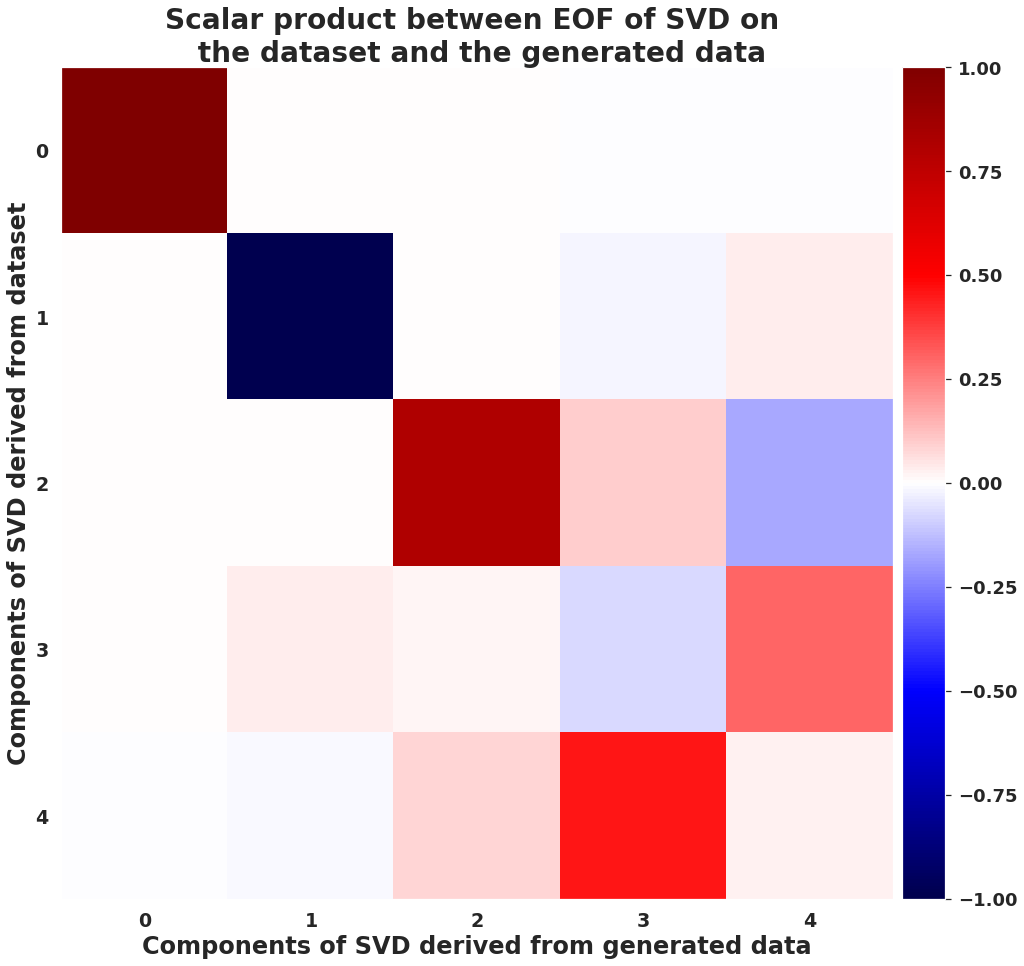

In [33]:
fig = plt.figure(figsize=(15,15))
axc = fig.add_subplot()
plt.subplots_adjust(top=0.95, right=0.87, left=0.1, hspace=0.1,bottom=0.01)
cim2 = plt.imshow(dp, cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()
plt.title('Scalar product between EOF of SVD on \n the dataset and the generated data', fontweight='bold', fontsize=28)
plt.xlabel('Components of SVD derived from generated data',  fontsize=24, fontweight='bold')
plt.ylabel('Components of SVD derived from dataset',  fontsize=24, fontweight='bold')
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.grid(False)
posn = axc.get_position()
cax22 = fig.add_axes([posn.x0+posn.width + 0.008, posn.y0, 0.04, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
cbar.ax.tick_params(labelsize=18)
#plt.savefig('./fig_82c/dp_eof.pdf')

In [34]:
print(fig)

Figure(1080x1080)


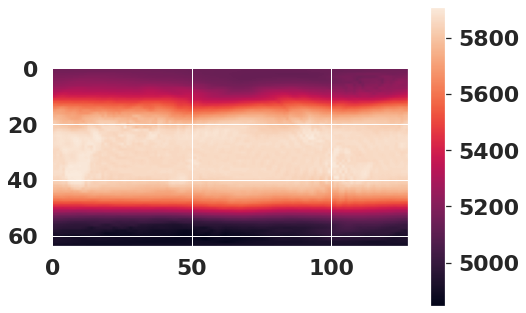

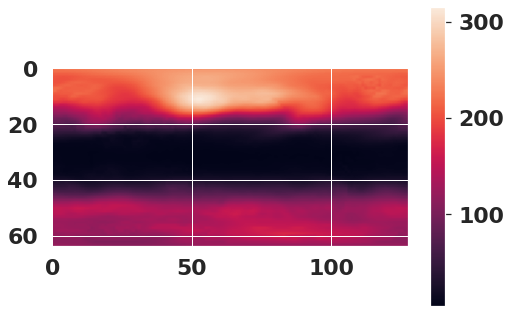

In [35]:
mX = np.mean(X, axis=0)
sX = np.std(X,axis=0)
plt.figure()
plt.imshow(mX)
plt.colorbar()
plt.figure()
plt.imshow(sX)
plt.colorbar()

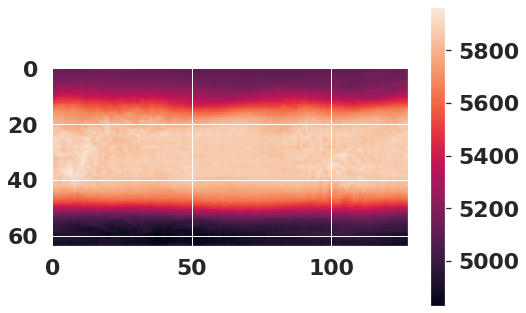

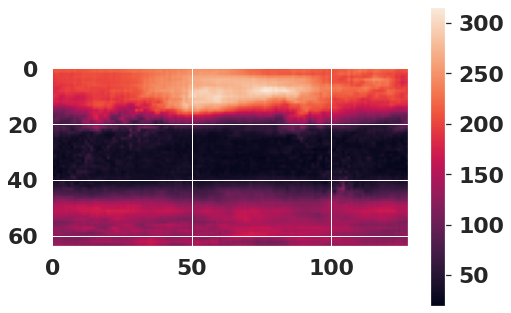

In [36]:
mXg = np.mean(Xg, axis=0)
sXg = np.std(Xg, axis=0)
plt.figure()
plt.imshow(mXg)
plt.colorbar()
plt.figure()
plt.imshow(sXg)
plt.colorbar()